In [ ]:
##### This jupyter notebook works a reprocessor for numpy (matrix of signals) or txt (single signal) scan files
##### Use this to reprocess a signal with a different algorithm/configurations/reference/etc.

In [1]:
import numpy as np
import datetime as dt
import scipy.signal as scs
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import sys
sys.path.append('D:\\gitCCA\\CESdesign\\py')
import CESfunctions_dev as cf

In [37]:
##### File loading
sample = np.load('D:\\CCA\\Avantes\\BBCEAS_Data\\20220316\\Isamples2203171312.npy')
background = np.loadtxt('D:\\CCA\\Avantes\\BBCEAS_Data\\20220316\\Ib2203161507.txt')
dateM,ppb1M,ppb2M,intM = cf.Mfile_read('D:\\CCA\\Avantes\\BBCEAS_Data\\20220316\\M2203171312.txt')
Mfile_rep_name = "D:\\CCA\\Avantes\\BBCEAS_Data\\20220316\\M2203171312_r.txt"
reference1=np.load("NO2_AvSC.npy")
reference2=np.load("CHOCHO_AvSC.npy")

##### Calibration of the wavelengths
calfactors=(2.47080093383789e2,1.69589176774025e-1,-3.51128119291388e-6,-1.37265324107183e-10)
wavelengths=cf.avantes_calibrator(len(sample[:,0]),*calfactors)
sample[:,0]=wavelengths[:,0]

##### Cavity and spectra parameters
lower_wavelength,upper_wavelength,distance,Reff=(445,459,70,.9994277)
dfactor = 1 - 150/5200

In [38]:
##### Cutting sprectra, defining I_sample and I_0
minwave,maxwave=cf.segment_indices(sample,lower_wavelength,upper_wavelength)
line=np.copy(sample[minwave:maxwave,:])
bckg=np.copy(background[minwave:maxwave,:])
ref1=np.copy(reference1[minwave:maxwave,:])
ref2=np.copy(reference2[minwave:maxwave,:])
I_0 = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)


In [39]:
##### The actual fitting algorithm
newppb1 = []
newppb2 = []
for i in range(1,len(line.T[:,0])):
    ### Must be adapted to the input and output of the algorithm
    alpha,fl,a,b,c,d = cf.fit_alg_1(line[:,i].reshape(len(line[:,i]),1),I_0,Reff,distance,ref1,ref2,
                                    verbose=0,parameters=1,choice=2)
    newppb1.append((c/2.504e10)/dfactor)
    newppb2.append((d/2.504e10)/dfactor)

In [40]:
newppb1_fa1=newppb1
newppb2_fa1=newppb2

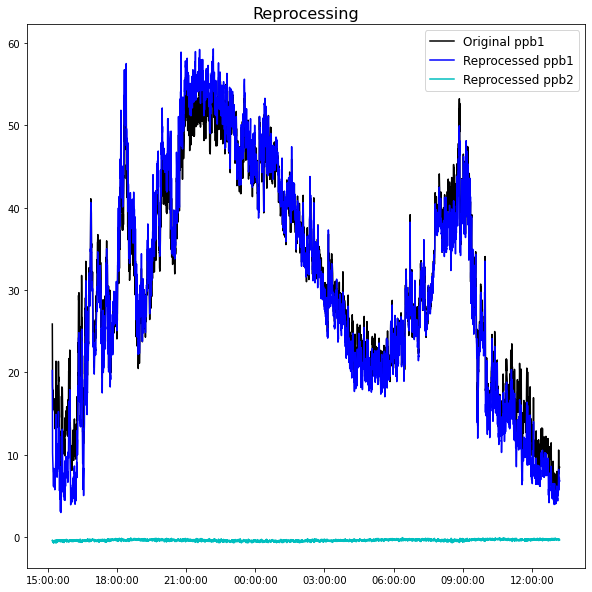

In [41]:
##### Compare the data
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
ax1.plot(dateM,ppb1M,'-k',label="Original ppb1")
#ax1.plot(dateM,newppb1_fa1,'-r',label="Reprocessed ppb1 fit_alg_1")
ax1.plot(dateM,newppb1,'-b',label="Reprocessed ppb1")
#ax1.plot(dateM,newppb2_fa1,'-m',label="Reprocessed ppb2 fit_alg_1")
ax1.plot(dateM,newppb2,'-c',label="Reprocessed ppb2")
ax1.xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))
ax1.set_title("Reprocessing",size=16)
ax1.legend(fontsize=12, loc='upper right')
#plt.savefig("Fit_alg_comparison-2.png")

In [42]:
##### Write new Mfile
timestamp = []
for ele in dateM:
    timestamp.append(ele.strftime("%Y/%m/%d-%H:%M:%S"))
newdata=[timestamp,newppb1,newppb2,intM]
with open(Mfile_rep_name,'w') as f:
    for x in zip(*newdata):
        f.write("{0} {1} {2} {3}\n".format(*x))

In [ ]:
newdata